In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'

RNA velocity assumed the following relationship between spliced and un-spliced reads:

$$ \frac{du}{dt} = \alpha - \beta u $$

$$ \frac{ds}{dt} = \beta u - \gamma s $$

where $u$ and $s$ are the un-spliced and spliced reads, respectively. $\alpha$, $\beta$, and $\gamma$ are the rate parameters of transcription, splicing and degradation.

# Adjusting Transcription Initiation Rate

Transcription initiation of genes might not be spontaneous and sudden. We first try to fit transcription initiation with a Hill function:

$$ \alpha(t) = \frac{\alpha_{max} \cdot t^n}{K^n + t^n} $$

where $\alpha(t)$ is the transcription rate at time $t$, $\alpha_{max}$ is the maximum transcription rate, $K$ is the time at which the transcription rate is half of the maximum, and $n$ is the Hill coefficient.

In [2]:
def hill(t, k, n, a, reverse = False):
    out = a * (t**n) / (k**n + t**n)

    if reverse: # If the process is inhibition
        out = a - out

    return out

In [3]:
def plot_hill(k, n, a, t, reverse = False, shift = 0, color='forestgreen', label = True):
    t_span = [0, t]
    t_span = np.linspace(t_span[0], t_span[1], t * 10)
    alpha = hill(t_span, k, n, a, reverse)


    if label:
        plt.plot(
            t_span + shift,
            alpha, 
            label = rf'a, $k = {k}, n = {n}, a_m = {a:.2f}$',
            color = color
        )
    else:
        plt.plot(
            t_span + shift,
            alpha, 
            color = color
        )
        
    plt.axvline(shift, color = '0.7', linestyle = '--')
    return alpha

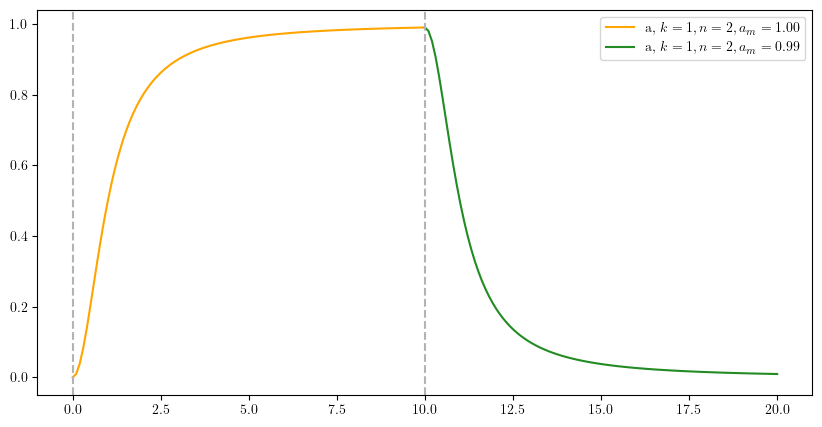

In [4]:
plt.figure(figsize=(10, 5))
alpha = plot_hill(1, 2, 1, 10, color='orange')
plot_hill(1, 2, alpha[-1], 10, reverse=True, shift=10)
plt.legend()

In [5]:
def system(t, y, k, n, a, beta, gamma, reverse = False):
    u, s = y 
    du_dt = beta * hill(t, k, n, a, reverse) - beta * u
    ds_dt = beta * u - gamma * s
    return [du_dt, ds_dt]

In [6]:
def plot_system(t, k, n, a, beta, gamma, shift = 0, reverse = False, start_point=[0, 0], u_color='darkorchid', s_color='darkorange', label = True):
    t_span = [0, t]
    sol = solve_ivp(
        system, 
        t_span, 
        start_point, 
        args = (k, n, a, beta, gamma, reverse),
        dense_output = True
    )
    t_eval = np.linspace(t_span[0], t_span[1], t * 10)
    u, s = sol.sol(t_eval)
    plt.axvline(shift, color = '0.7', linestyle = '--')
    if label:
        plt.plot(t_eval + shift, u, color = u_color)
        plt.plot(t_eval + shift, s, color = s_color)
    else:
        plt.plot(t_eval + shift, u, label = rf'$u, \beta = {beta}, \gamma = {gamma}$', color = u_color)
        plt.plot(t_eval + shift, s, label = rf'$s, \beta = {beta}, \gamma = {gamma}$', color = s_color)
    a_mask = hill(t, k, n, a, reverse)
    return sol, a_mask

def plot_portrait(sol1, sol2, beta, gamma, t1, t2):
    t_span1 = [0, t1]
    t_eval1 = np.linspace(t_span1[0], t_span1[1], t1 * 10)
    u_up, s_up = sol1.sol(t_eval1)

    t_span2 = [0, t2]
    t_eval2 = np.linspace(t_span2[0], t_span2[1], t2 * 10)
    u_down, s_down = sol2.sol(t_eval2)
    
    plt.figure(figsize=(5,5))
    plt.plot(s_up, u_up, label = 'Initiation', color='firebrick')
    plt.plot(s_down, u_down, label = 'Termination', color='royalblue')

    s_line = np.linspace(0, s_up[-1], 100)
    u_line = gamma / beta * s_line
    plt.plot(s_line, u_line, label=r'$u = \frac{\gamma}{\beta} s$', color = '0.7', linestyle = '--')
    plt.xlabel(r'$s(t)$')
    plt.ylabel(r'$u(t)$')
    plt.legend()


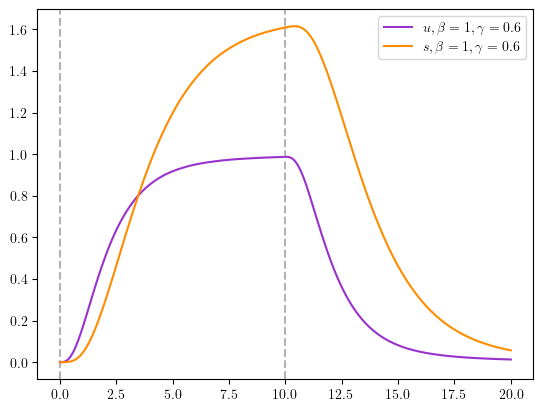

In [7]:
sol, a_mask = plot_system(10, 1, 2, 1, 1, 0.6, start_point=[0, 0], reverse=False)
plot_system(10, 1, 2, a_mask, 1, 0.6, start_point=[sol.y[0][-1], sol.y[1][-1]], reverse=True, shift=10, label=False)
plt.legend()

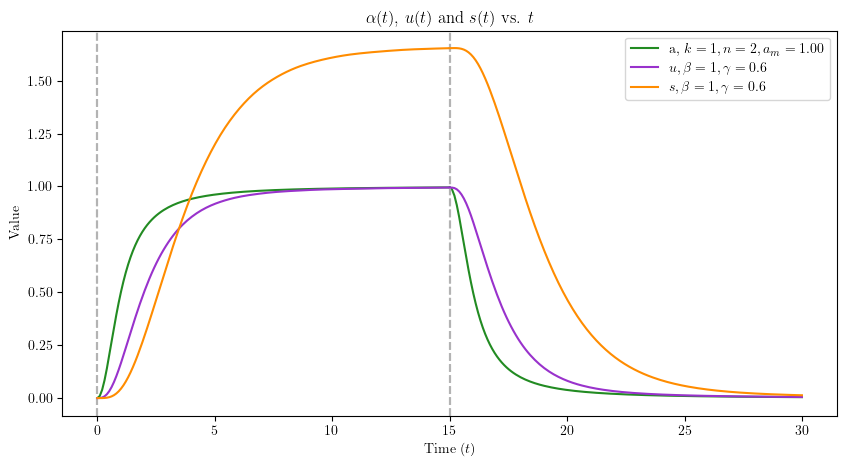

In [14]:
plt.figure(figsize=(10, 5))
alpha = plot_hill(1, 2, 1, 15)
plot_hill(1, 2, alpha[-1], 15, reverse=True, shift=15, label=False)
sol_up, a_mask = plot_system(15, 1, 2, 1, 1, 0.6, start_point=[0, 0], reverse=False)
sol_down, a_mask_down = plot_system(15, 1, 2, a_mask, 1, 0.6, start_point=[sol_up.y[0][-1], sol_up.y[1][-1]], reverse=True, shift=15, label=False)
plt.legend()
plt.title(r'$\alpha (t)$, $u(t)$ and $s(t)$ vs. $t$')
plt.ylabel(r'Value')
plt.xlabel(r'Time ($t$)')
plt.savefig('../figures/fig*_ode_hill_same_k.png', dpi=300, bbox_inches='tight')

In [9]:
sol_up

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x13b462ce0>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 3.79396938e-01, 7.18509515e-01, 1.24408810e+00,
       1.87396655e+00, 2.96566749e+00, 4.06953038e+00, 5.30073595e+00,
       6.76894769e+00, 8.54623030e+00, 1.07393705e+01, 1.34404406e+01,
       1.50000000e+01])
 t_events: None
        y: array([[0.00000000e+00, 3.33324998e-13, 4.43544363e-10, 4.54581109e-07,
        4.41396624e-04, 1.52610717e-02, 7.93682758e-02, 2.49910176e-01,
        4.65906546e-01, 7.27034822e-01, 8.61012244e-01, 9.29549463e-01,
        9.63942886e-01, 9.80528762e-01, 9.88772637e-01, 9.93108369e-01,
        9.94754335e-01],
       [0.00000000e+00, 8.33306664e-18, 1.21965337e-13, 1.26051299e-09,
        1.21940757e-05, 1.44754324e-03, 1.4

<Figure size 1000x1000 with 0 Axes>

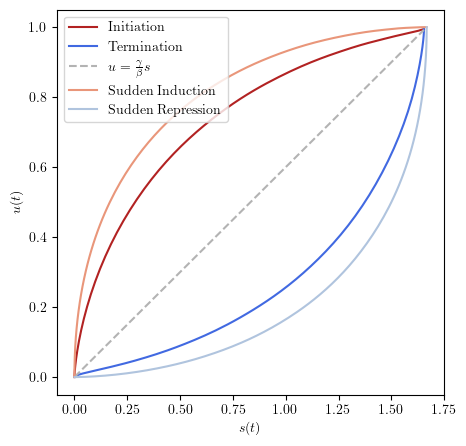

In [24]:
def system1(t, y):
    u, s = y
    du_dt = 1 - 1 * u
    ds_dt = 1 * u - 0.6 * s
    return [du_dt, ds_dt]

def system2(t, y):
    u, s = y
    du_dt =  - 1 * u
    ds_dt = 1 * u - 0.6 * s
    return [du_dt, ds_dt]

t_span = [0,15]
t_eval = np.linspace(t_span[0], t_span[1], 500)

u0 = 0; s0 = 0
sol_up_old = solve_ivp(system1, t_span, [u0, s0], t_eval=t_eval)

u1 = 1; s1 = 1 / 0.6
sol_down_old = solve_ivp(system2, t_span, [u1, s1], t_eval=t_eval)

plt.figure(figsize = (10, 10))
plot_portrait(sol_up, sol_down, 1, 0.6, 15, 15)
plt.plot(sol_up_old.y[1], sol_up_old.y[0], label='Sudden Induction', color = 'darksalmon')
plt.plot(sol_down_old.y[1], sol_down_old.y[0], label='Sudden Repression', color='lightsteelblue')
plt.legend()
plt.savefig('../figures/fig*_portrait_comparison.png', dpi=300, bbox_inches='tight')


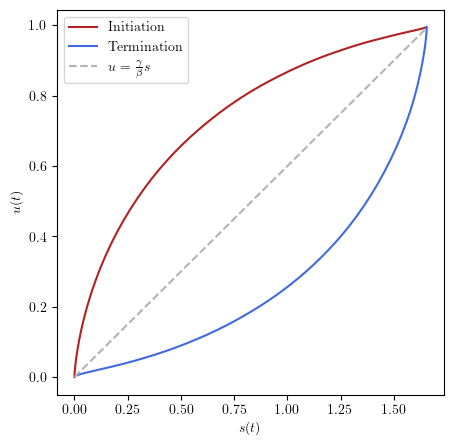

In [15]:
plot_portrait(sol_up, sol_down, 1, 0.6, 15, 15)

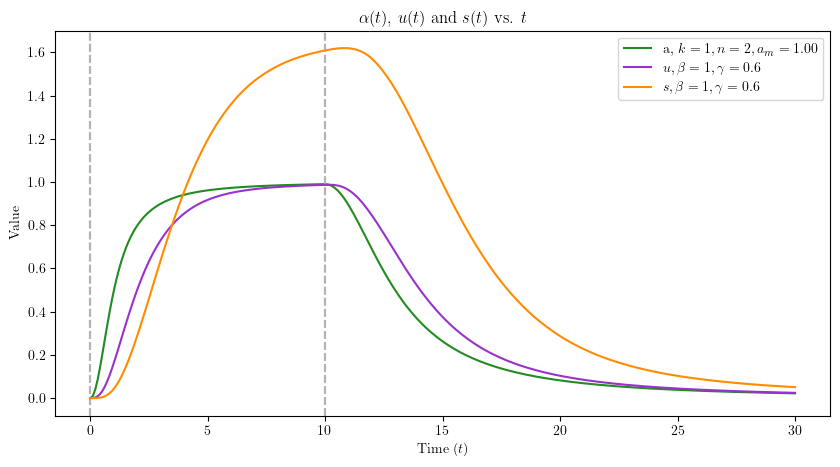

In [12]:
plt.figure(figsize=(10, 5))
alpha = plot_hill(1, 2, 1, 10)
plot_hill(3, 2, alpha[-1], 20, reverse=True, shift=10, label=False)
sol_up, a_mask = plot_system(10, 1, 2, 1, 1, 0.6, start_point=[0, 0], reverse=False)
sol_down, a_mask_down = plot_system(20, 3, 2, a_mask, 1, 0.6, start_point=[sol.y[0][-1], sol.y[1][-1]], reverse=True, shift=10, label=False)
plt.legend()
plt.title(r'$\alpha (t)$, $u(t)$ and $s(t)$ vs. $t$')
plt.ylabel(r'Value')
plt.xlabel(r'Time ($t$)')
plt.savefig('../figures/fig*_ode_hill_different_k.png', dpi=300, bbox_inches='tight')

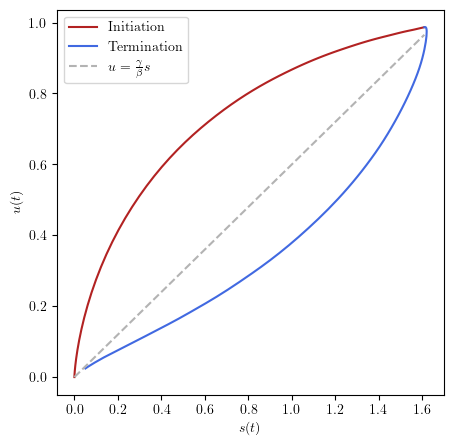

In [13]:
plot_portrait(sol_up, sol_down, 1, 0.6, 10, 20)
plt.savefig('../figures/fig*_portrait_hill_different_k.png', dpi=300, bbox_inches='tight')